## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.
* Implement video processing pipeline


* Note: Make sure you use the correct grayscale conversion depending on how you've read in your images. Use cv2.COLOR_RGB2GRAY if you've read in an image using mpimg.imread(). Use cv2.COLOR_BGR2GRAY if you've read in an image using cv2.imread().

---
## First, I'll compute the camera calibration using chessboard images

In [2]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib qt

def points():
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob('camera_cal/calibration*.jpg')

    # Step through the list and search for chessboard corners
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)
    
        # If found, add object points, image points
        if ret == True:
            imgpoints.append(corners)
            objpoints.append(objp)
            
        
            # Draw and display the corners
            img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
            cv2.imshow('img',img)
            cv2.waitKey(500)

    cv2.destroyAllWindows()
    
    return objpoints, imgpoints

## Apply Distortion correction

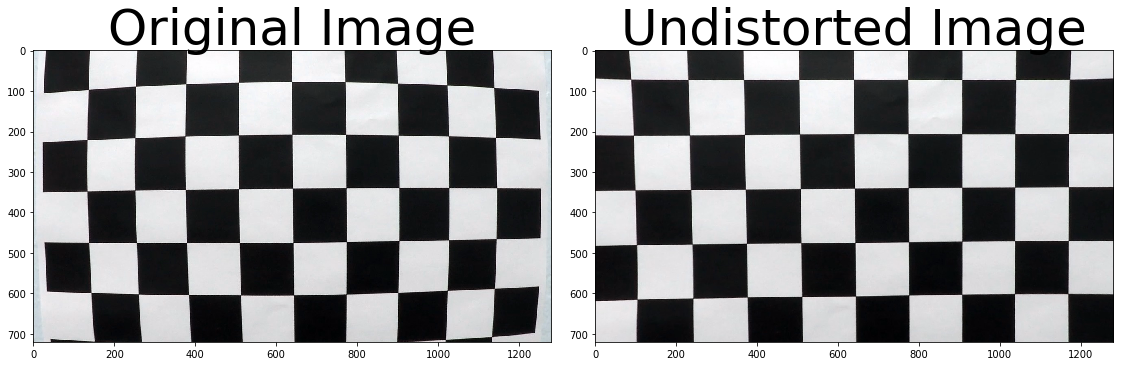

In [3]:
img = cv2.imread('camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

objpoints, imgpoints = points()
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

def cal_undistort(img):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

def cal_undistort_extract(img, objpoints, imgpoints):
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist, mtx, dist

undistorted, mtx, dist = cal_undistort_extract(img, objpoints, imgpoints)
undistort = cal_undistort(img)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistort)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [4]:
def show_images(images, cmap=None):
    cols = 2
    rows = (len(images)+1)//cols
    
    plt.figure(figsize=(10, 11))
    for i, image in enumerate(images):
        plt.subplot(rows, cols, i+1)
        cmap = 'gray' if len(image.shape)==2 else cmap
        plt.imshow(image, cmap=cmap)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout()
    plt.show()

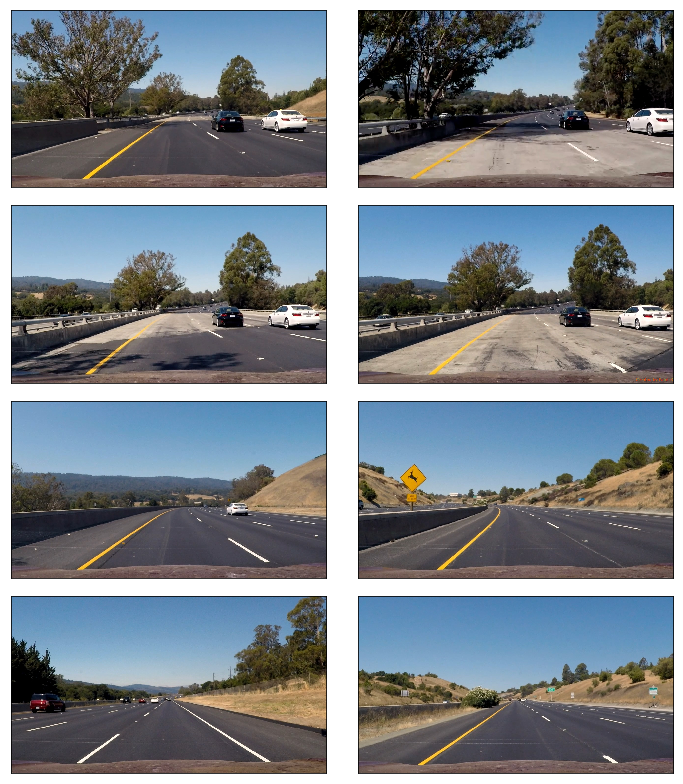

In [5]:
test_images = [mpimg.imread(path) for path in glob.glob('test_images/*.jpg')]
show_images(test_images)

## Apply distortion correction to raw images

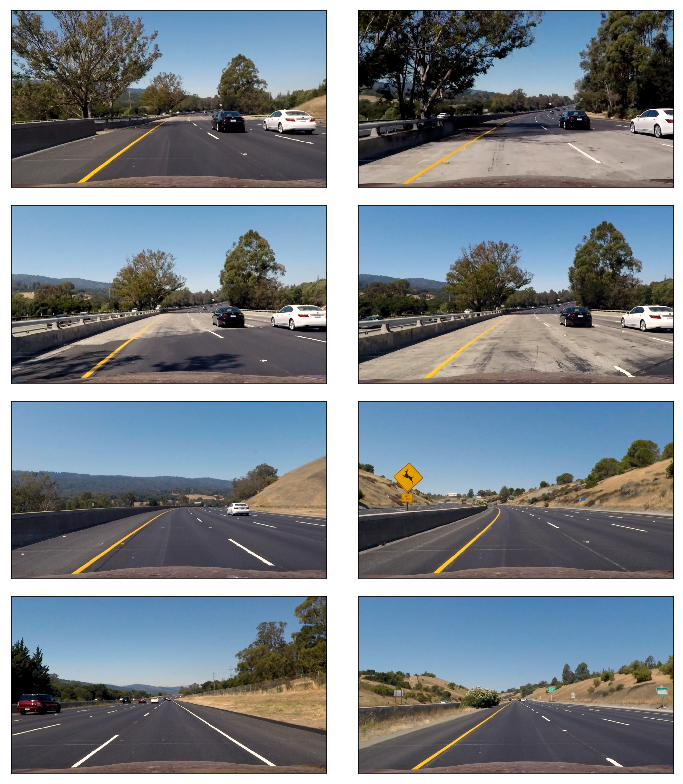

In [6]:
undistorted_images = []

for i in range(len(test_images)):
    undistorted = cal_undistort(test_images[i])
    undistorted_images.append(undistorted)
    
show_images(undistorted_images)

## Use color transforms gradients and create a thresholded binary images

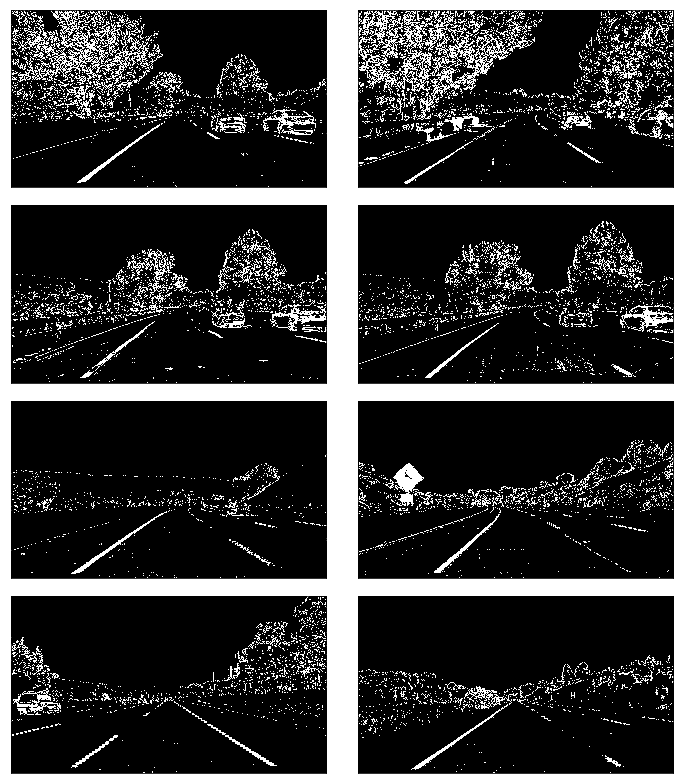

In [7]:
# image is expected be in RGB color space
def hls_s(image, s_thresh=(170, 255), sx_thresh=(20, 100)):
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    
    return combined_binary

hls_images = []

#hls_image = hls_s(image)
#plt.imshow(image_yw)

for i in range(len(undistorted_images)):
    hls_image = hls_s(undistorted_images[i])
    hls_images.append(hls_image)
    
show_images(hls_images)

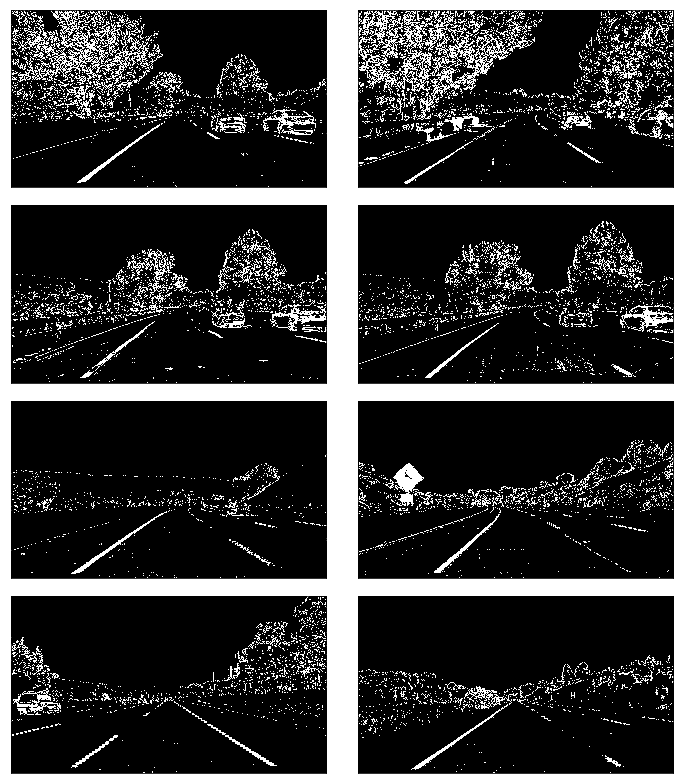

In [8]:
# Apply smothing

def apply_smoothing(image, kernel_size=1):
    """
    kernel_size must be postivie and odd
    """
    smoothing = cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)
    
    return smoothing

smooth_images = []

for i in range(len(hls_images)):
    smooth = apply_smoothing(hls_images[i])
    smooth_images.append(smooth)
    
show_images(smooth_images)



## Apply a perspective transform to rectify binary image ("birds-eye view").

* Select region of interest

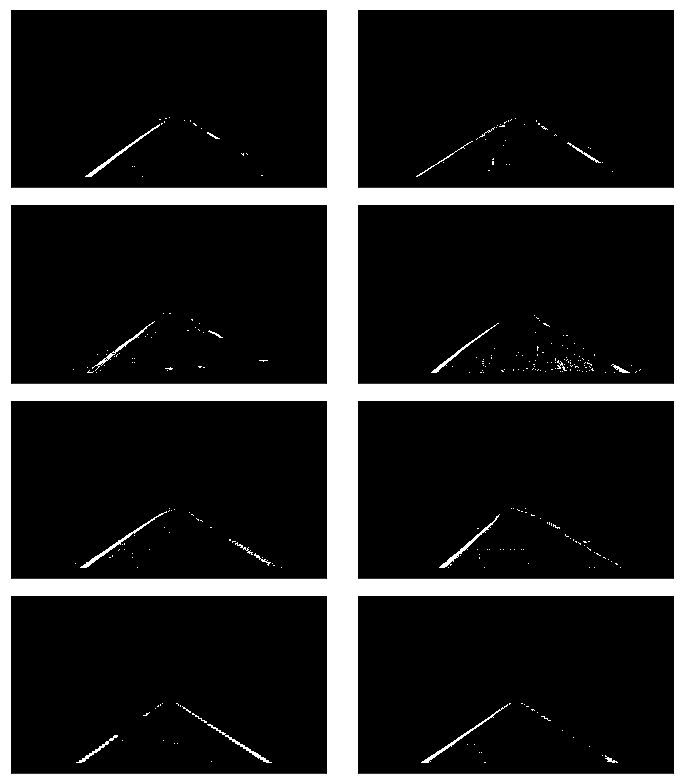

In [9]:
def filter_region(image, vertices):
    """
    Create the mask using the vertices and apply it to the input image
    """
    mask = np.zeros_like(image)
    if len(mask.shape)==2:
        cv2.fillPoly(mask, vertices, 255)
    else:
        cv2.fillPoly(mask, vertices, (255,)*mask.shape[2]) # in case, the input image has a channel dimension        
    return cv2.bitwise_and(image, mask)

def select_region(image):
    """
    It keeps the region surrounded by the `vertices` (i.e. polygon).  Other area is set to 0 (black).
    """
    # first, define the polygon by vertices
    rows, cols = image.shape[:2]
    #bottom_left  = [cols*0.1, rows*0.95]
    #top_left     = [cols*0.49, rows*0.59]
    #bottom_right = [cols*0.9, rows*0.95]
    #top_right    = [cols*0.58, rows*0.59]
    
    bottom_left  = [230, 680]
    top_left     = [615, 435]
    bottom_right = [1175, 680]
    top_right    = [695, 435]
    
    # the vertices are an array of polygons (i.e array of arrays) and the data type must be integer
    vertices = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)
    return filter_region(image, vertices)

roi_images = []

for i in range(len(smooth_images)):
    roi_image = select_region(smooth_images[i])
    roi_images.append(roi_image)
    
show_images(roi_images)

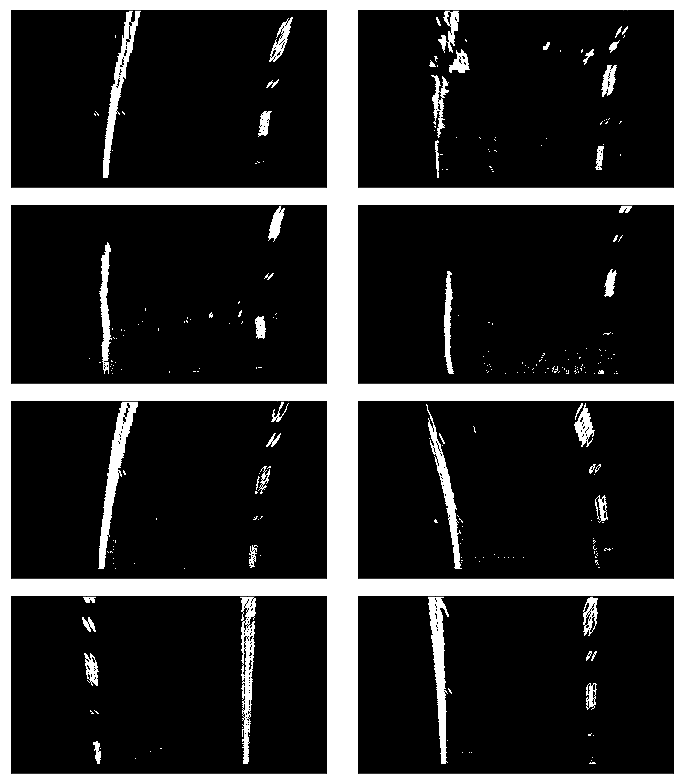

In [10]:
# Define a function that takes an image, number of x and y points, 
# camera matrix and distortion coefficients
def warp(image):
    
    img_size = (image.shape[1], image.shape[0])  
    #top_right_src = [695, 450]
    #bottom_right_src = [1135, 720]
    #bottom_left_src = [210, 720]
    #top_left_src = [600, 450]
    
    top_right_src = [705, 459]
    bottom_right_src = [1135, 720]
    bottom_left_src = [210, 720]
    top_left_src = [590, 459]

    
    top_right_dst = [970, 0]
    bottom_right_dst = [970, 700]
    bottom_left_dst = [350, 700]
    top_left_dst = [350, 0]
    
    src = np.float32([top_right_src, bottom_right_src, bottom_left_src, top_left_src])
    #dst = np.float32([bottom_left, [cols*0.1, rows*0.65], bottom_right, [cols*0.9, rows*0.62]])
    dst = np.float32([top_right_dst, bottom_right_dst, bottom_left_dst, top_left_dst])
    
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(image, M, img_size, flags=cv2.INTER_LINEAR)
    
    return warped, Minv

warped_images = []
Minvs = []

for i in range(len(smooth_images)):
    warped_image, Minv = warp(roi_images[i])
    warped_images.append(warped_image)
    Minvs.append(Minv)
    
    
show_images(warped_images)

## Detect lane pixelsand fit to find the lane boundary

* Sliding Windows

In [11]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    # Rectangle data
    rectangle_data = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        rectangle_data.append((win_y_low, win_y_high, win_xleft_low, win_xleft_high, win_xright_low, win_xright_high))

        # Draw the windows on the visualization image
        #cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        #(win_xleft_high,win_y_high),(0,255,0), 2) 
        #cv2.rectangle(out_img,(win_xright_low,win_y_low),
        #(win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # ]If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    left_fit, right_fit = (None, None)
    # Fit a second order polynomial to each using 'np.polyfit'
    if len(leftx) != 0:
        left_fit = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit = np.polyfit(righty, rightx, 2)
        
    visualization_data = (rectangle_data, histogram)
        
    # Generate x and y values for plotting
    #ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    #try:
    #    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    #    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    #except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
    #    print('The function failed to fit a line!')
    #    left_fitx = 1*ploty**2 + 1*ploty
    #   right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    #out_img[lefty, leftx] = [255, 0, 0]
    #out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')
    

    return left_fit, right_fit, left_lane_inds, right_lane_inds, visualization_data

left_fit, right_fit, left_lane_inds, right_lane_inds, visualization_data = find_lane_pixels(warped_images[4])


* Visiualizing sliding window method

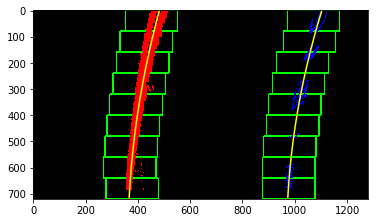

In [12]:
def plot_w(img_out):# Generate x and y values for plotting
    
    left_fit, right_fit, left_lane_inds, right_lane_inds, visualization_data = find_lane_pixels(img_out)
    
    h = img_out.shape[0]
    
    out_img = np.dstack((img_out, img_out, img_out))
    
    left_fitx_int = left_fit[0]*h**2 + left_fit[1]*h + left_fit[2]
    right_fitx_int = right_fit[0]*h**2 + right_fit[1]*h + right_fit[2]
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img_out.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
     # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    rectangles = visualization_data[0]
    histogram = visualization_data[1]
    
    ploty = np.linspace(0, img_out.shape[0]-1, img_out.shape[0])
    
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    ## Visualization ##
    for i in rectangles:
        cv2.rectangle(out_img,(i[2],i[0]),(i[3],i[1]),(0,255,0), 3) 
        cv2.rectangle(out_img,(i[4],i[0]),(i[5],i[1]),(0,255,0), 3) 
        
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    plt.imshow(out_img)
    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    
    return out_img

image_w1 = plot_w(warped_images[4])



* Search from prior

In [13]:

def search_around_poly(binary_warped, left_fit_prev, right_fit_prev):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 80

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds =((nonzerox > (left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy + 
                    left_fit_prev[2] - margin)) & (nonzerox < (left_fit_prev[0]*(nonzeroy**2) + 
                    left_fit_prev[1]*nonzeroy + left_fit_prev[2] + margin)))
                    
    right_lane_inds = ((nonzerox > (right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy + 
                    right_fit_prev[2] - margin)) & (nonzerox < (right_fit_prev[0]*(nonzeroy**2) + 
                    right_fit_prev[1]*nonzeroy + right_fit_prev[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    #NEW
    left_fit_new, right_fit_new = (None, None)
    if len(leftx) != 0:
        left_fit_new = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit_new = np.polyfit(righty, rightx, 2)

    # Fit new polynomials
    #left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    return left_fit_new, right_fit_new, left_lane_inds, right_lane_inds

left_fit_new, right_fit_new, left_lane_inds_new, right_lane_inds_new = search_around_poly(warped_images[4], left_fit, right_fit)


* visualizing search from prior

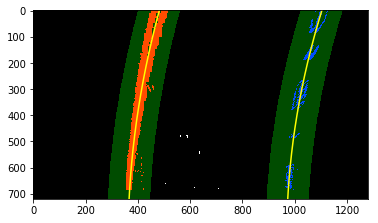

In [14]:
def plot_prior(img_out):
    margin = 80
    
    left_fit, right_fit, left_lane_inds, right_lane_inds, visualization_data = find_lane_pixels(img_out)
    left_fit2, right_fit2, left_lane_inds2, right_lane_inds2 = search_around_poly(img_out, left_fit, right_fit)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_out.shape[0]-1, img_out.shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit_new[1]*ploty + left_fit_new[2]
    right_fitx = right_fit_new[0]*ploty**2 + right_fit_new[1]*ploty + right_fit_new[2]
    left_fitx2 = left_fit2[0]*ploty**2 + left_fit2[1]*ploty + left_fit2[2]
    right_fitx2 = right_fit2[0]*ploty**2 + right_fit2[1]*ploty + right_fit2[2]
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((img_out, img_out, img_out))*255
    window_img = np.zeros_like(out_img)
    
    # Grab activated pixels
    nonzero = img_out.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    plt.imshow(result)
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx2, ploty, color='yellow')
    plt.plot(right_fitx2, ploty, color='yellow')
    ## End visualization steps ##
    
    return result

result = plot_prior(warped_images[4])
  

## Determine the radius of both lanes

## Determine vehicle's position with respect to center

In [15]:
def curv_rad_and_center_dist(bin_img, l_fit, r_fit, l_lane_inds, r_lane_inds):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension, the lane is about 30 meters long and 
    xm_per_pix = 3.7/700 # meters per pixel in x dimension, 3.7 meters wide.
    left_curverad, right_curverad, center_dist = (0, 0, 0)
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    h = bin_img.shape[0]
    ploty = np.linspace(0, h-1, h)
    y_eval = np.max(ploty)
  
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = bin_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Again, extract left and right line pixel positions
    leftx = nonzerox[l_lane_inds]
    lefty = nonzeroy[l_lane_inds] 
    rightx = nonzerox[r_lane_inds]
    righty = nonzeroy[r_lane_inds]
    
    if len(leftx) != 0 and len(rightx) != 0:
        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
        # Calculate the new radii of curvature
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        # Now our radius of curvature is in meters
    
    # Distance from center is image x midpoint - mean of l_fit and r_fit intercepts 
    if r_fit is not None and l_fit is not None:
        car_position = bin_img.shape[1]/2
        l_fit_x_int = l_fit[0]*h**2 + l_fit[1]*h + l_fit[2]
        r_fit_x_int = r_fit[0]*h**2 + r_fit[1]*h + r_fit[2]
        lane_center_position = (r_fit_x_int + l_fit_x_int) /2
        center_dist = (car_position - lane_center_position) * xm_per_pix
    return left_curverad, right_curverad, center_dist

rad_l, rad_r, d_center = curv_rad_and_center_dist(warped_images[4], left_fit, right_fit, left_lane_inds, right_lane_inds)

print(rad_l, rad_r)
print(d_center)

1071.4969283873368 926.5098949740745
-0.15806817909807602


## Warp the detected lane boundaries back onto the original image.

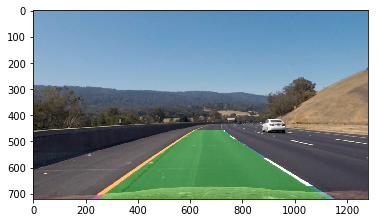

In [16]:
def warp_b (bin_img, undis_img, Minv, left_fit, right_fit):
    c_img = np.copy(undis_img)
    if left_fit is None or right_fit is None:
        return image
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(bin_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    h = bin_img.shape[0]
    w = bin_img.shape[1]
    ploty = np.linspace(0, h-1, h)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2] 
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,0,255), thickness=15)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0,255,255), thickness=15)


    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (w, h)) 

    # Combine the result with the original image
    result = cv2.addWeighted(undis_img, 1, newwarp, 0.3, 0)
    return result

result = warp_b(warped_images[4], undistorted_images[4], Minvs[4], left_fit, right_fit)

plt.imshow(result)

## Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position. 

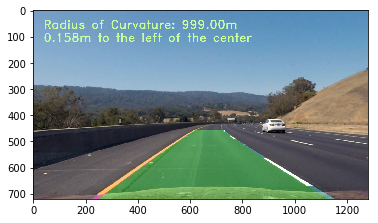

In [17]:
def visual_display(result, curv_rad, center_dist):
    result2 = np.copy(result)
    h = result2.shape[0]
    font = cv2.FONT_HERSHEY_DUPLEX
    text = 'Radius of Curvature: ' + '{:04.2f}'.format(curv_rad) + 'm'
    cv2.putText(result2, text, (40,70), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    direction = ''
    if center_dist > 0:
        direction = 'to the right'
    elif center_dist < 0:
        direction = 'to the left'
    abs_center_dist = abs(center_dist)
    text = '{:04.3f}'.format(abs_center_dist) + 'm ' + direction + ' of the center'
    cv2.putText(result2, text, (40,120), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    return result2

result2 = visual_display(result, (rad_l+rad_r)/2, d_center)
plt.imshow(result2)

## Define a class to receive the characteristics of each line detection

In [18]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = []  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #number of detected pixels
        self.px_count = None
        
    def add_fit(self, fit, inds):
        #add a found fit to the line - up to n 
        if fit is not None: 
            if self.best_fit is not None: 
                # if we have a best fit, see how this new fit compares
                self.diffs = abs(fit-self.best_fit)
            if (self.diffs[0] > 0.001 or self.diffs[1] > 1.0 or self.diffs[2] > 100) and len(self.current_fit) > 0:
                self.detected = False
            else:
                self.detected = True
                self.px_count = np.count_nonzero(inds)
                self.current_fit.append(fit)
                if len(self.current_fit) > 13:
                        #through out old fits, keep newest n
                    self.current_fit = self.current_fit[len(self.current_fit)-13:]
                self.best_fit = np.average(self.current_fit, axis=0)     
        #Remove one from the history if not found. 
        else:
            self.detected = False
            if len(self.current_fit) > 0:
                #Through out oldest fit 
                self.current_fit = self.current_fit[:len(self.current_fit)-1]
            if len(self.current_fit) > 0:
                # if there are still any fits in the queue, best_fit is their average
                self.best_fit = np.average(self.current_fit, axis=0)
                
                    
     
       
    
        

## Define Pipeline

In [19]:


def pipeline(img):
    n_image = np.copy(img)
    undist_image = cal_undistort(n_image)
    hls_image = hls_s(undist_image)
    smooth_image = apply_smoothing(hls_image)
    roi_image = select_region(smooth_image)    
    warped_image, Minv = warp(roi_image)
    
    if not l_line.detected or not r_line.detected:
        l_fit, r_fit, l_lane_inds, r_lane_inds, _ = find_lane_pixels(warped_image)
    else:
        l_fit, r_fit, l_lane_inds, r_lane_inds = search_around_poly(warped_image, l_line.best_fit, r_line.best_fit)

    l_line.add_fit(l_fit, l_lane_inds)
    r_line.add_fit(r_fit, r_lane_inds)
    
    # draw the current best fit if it exists
    if l_line.best_fit is not None and r_line.best_fit is not None:
        result = warp_b(warped_image, undist_image, Minv, l_line.best_fit, r_line.best_fit)
        rad_l, rad_r, d_center = curv_rad_and_center_dist(warped_image, l_line.best_fit, r_line.best_fit, l_lane_inds, r_lane_inds)
        result2 = visual_display(result, (rad_l+rad_r)/2, d_center)
    else:
        result2 = n_image
       
    return result2

l_line = Line()
r_line = Line()
#image_test = mpimg.imread('test_images/test3.jpg')
#image_test = test_images[3]
#pipe_image = pipeline(test_images[1])
#plt.imshow(pipe_image)
#print(pipe_image)



In [20]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    
    # TODO: put your pipeline here,
    result = pipeline(image)
    # you should return the final output (image where lines are drawn on lanes)

    return result

In [21]:
white_output = 'video_output/project_video_f1.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video 2.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)
#.subclip(0,10)

[MoviePy] >>>> Building video video_output/project_video_f1.mp4
[MoviePy] Writing video video_output/project_video_f1.mp4


100%|█████████▉| 1260/1261 [02:45<00:00,  7.71it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: video_output/project_video_f1.mp4 

CPU times: user 3min, sys: 29.9 s, total: 3min 30s
Wall time: 2min 47s


## Here is the link to my video

https://youtu.be/jbsBxRbOjLM

## Discussion

Here I'll talk about the approach I took and the main issues I went through to achieve the result posted in the link above. 

I didn't do anything different from the content in the course, actually I followed every step/goal as depicted in the project rubric/template. The most challenging part for me was to understand how to use the properties of the class lane to determine when to use the sliding windows method or the search around method. The pipeline has opportunities for improvements to determine the source points and the destination points when warping the image. 

I was fascinated about the sliding windows method and how it all starts with the histogram peaks, but the hardest part was to really make sense of the code when using polyfit to fit a polynomial with the activated pixels for each line and then how to iterate going up to the lane sliding the widnows defined in the hypeparameters. 

The other challenging part was to install moviepy in my computer, as the imageo lib had a version issue that took me a long time to resolve. I thought that Anaconda resolved most of the problems of the libraries versioning issues when it comes to libraries but it seems that this one was not the case. 

This was a fun project and I learned a lot of computer vision. I can say I am delighted in developing a decent lane line detection algorithm. 

Thanks, 
